In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.manifold import TSNE
import numpy as np
import copy
import scipy


c:\msc_project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


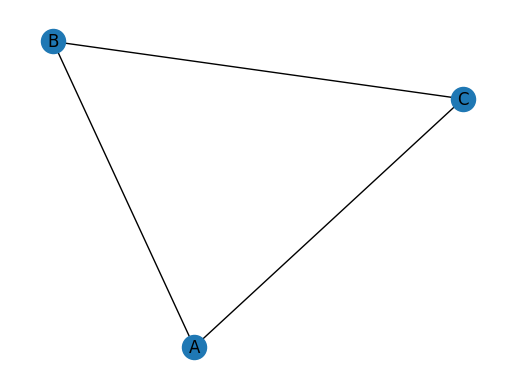

In [3]:
G = nx.Graph()

G.add_node('A')
G.add_nodes_from(['B', 'C'])

G.add_edge('A', 'B')
G.add_edges_from([('B', 'C'), ('A', 'C')])

fig, ax = plt.subplots()
nx.draw_networkx(G)
ax.set_facecolor('white')
ax.axis('off')
fig.set_facecolor('white')

In [4]:
# Zachary's Karate club
G = nx.karate_club_graph()
karate_pos = nx.spring_layout(G, k=0.3)
# nx.draw_networkx(G, karate_pos)

print(list(G.nodes))
# print(list(G.edges))
# for i in list(G):
#     print(G.degree(list(G)[i]), "")


# The club instructor, Mr. Hi, has node ID "0"
mr_hi = 0 
#print(mr_hi in G) 
#print(G.has_node(mr_hi)) 

# Mr Hi's friends are:
#print(list(G.neighbors(mr_hi)))

# The president of the karate club, nicknamed John A., is represented by ID 33, is not a friend of My Hi.
john_a = 33 
#print((mr_hi, john_a) in G.edges)
#print(G.has_edge(mr_hi, john_a))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


<class 'networkx.classes.graph.Graph'>


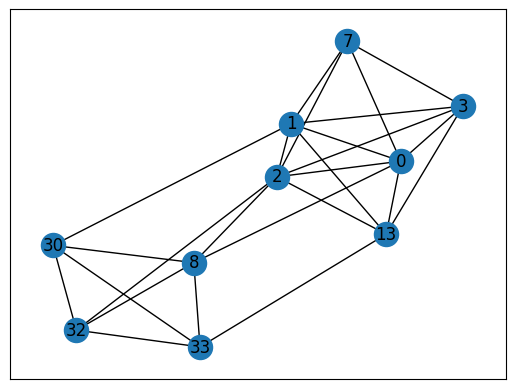

In [85]:
# https://networkx.org/documentation/networkx-2.0/reference/algorithms/generated/networkx.algorithms.core.k_shell.html

G = nx.karate_club_graph()

k_shell_sub_graph = nx.core.k_shell(G)
print(type(k_shell_sub_graph))
nx.draw_networkx(k_shell_sub_graph)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 43.46it/s]


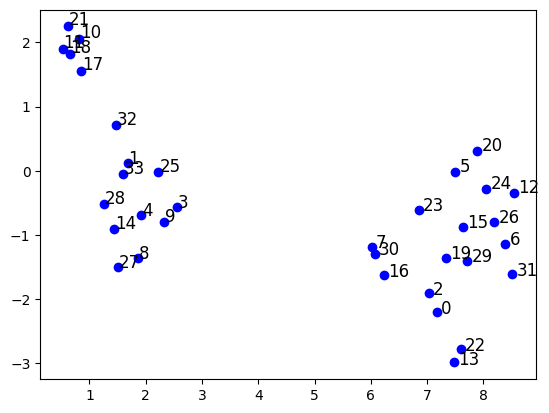

In [86]:
# Create Embedding
node2vec = Node2Vec(G, dimensions=4)

model = node2vec.fit(window=10)

embeddings = np.array([model.wv[x] for x in G.nodes])

# Save embeddings for later use
model.wv.save_word2vec_format("karate_embedding.txt")

# reduce the dimension using t-SNE
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

# visualise the embeddings
for i in range(len(embeddings_2d)):
    x = embeddings_2d[i][0]
    y = embeddings_2d[i][1]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)

Methods
The k-shell decomposition. The algorithm starts by removing all nodes with degree k= 1. After 
removing all nodes with k= 1, there may appear some nodes with only one link left. We iteratively 
remove these nodes until there is no node left with k= 1. The removed nodes are assigned with an index 
kS= 1 and are considered in the 1-shell. In a similar way, nodes with degree k≤ 2 are iteratively removed 
and assigned an index kS= 2. This pruning process continues removing higher shells until all nodes are 
removed. Isolated nodes are assigned an index kS= 0. As a result, each node is assigned a kS index, and 
the network can be viewed as a hierarchical structure from the innermost shell to the periphery shell.

In [7]:
# implement NLC(i)
G = nx.karate_club_graph()



# nx.draw_networkx(copy_G_for_k_shell)
print("original graph", list(G))

def getKShellDict(G):
    copy_G_for_k_shell = copy.deepcopy(G)
    k_shell_dict = dict()
    k_shell_value = 0

    max_degree = 0
    degree_list = []
    for i in range(0,len(list(G))):
        degree_list.append((list(G)[i], G.degree[list(G)[i]]))
        if max_degree < G.degree[list(G)[i]]:
            max_degree = G.degree[list(G)[i]]
    
    degree_list.sort(key = lambda x: x[1])
    print(degree_list)

    each_k_shell_count = 0 
    finish_flg = False
    # calculate k-shell value for each node
    while not finish_flg:
        each_value_finish_flg = False
        while not each_value_finish_flg:
            each_k_shell_count = 0
            loop_count = 0
            for i in range(0, len(list(G))):
        
                if G.degree[list(G)[i]] <= k_shell_value:
                    each_k_shell_count += 1
                    k_shell_dict[list(G)[i]] = k_shell_value
                    print(k_shell_dict)
                    print("k_shell_value:", k_shell_value)
                    print("i:", i)
                    copy_G_for_k_shell.remove_node(list(G)[i])
                    i += 1
            G = copy.deepcopy(copy_G_for_k_shell)
            if len(list(G.nodes)) == 0:
                finish_flg = True

            if each_k_shell_count == 0:
                each_value_finish_flg = True
                k_shell_value += 1
    return k_shell_dict

# return the set of nodes which are in the theid-level neighborhoods of node i
def thirdLevelNeighbors(G, i):
    first_neighbors = set([n for n in G.neighbors(i)])
    print("first neighbor", first_neighbors)
    result_neighbors = set()
    result_neighbors = result_neighbors | first_neighbors
    
    second_neighbors = set()
    for j in first_neighbors:
        second_neighbors = first_neighbors | set([n for n in G.neighbors(j)])
    print("second neighbors:", second_neighbors)

    third_neighbors = set()
    for j in second_neighbors:
        third_neighbors = third_neighbors | set([n for n in G.neighbors(j)])

    return first_neighbors | second_neighbors | third_neighbors


# calculate NLC of node n
def getNLC(G, n):
    k_shell = getKShellDict(G)
    neighbors = thirdLevelNeighbors(G,n)

    node2vec_dict = dict()

    with open("karate_embedding.txt") as f:
        for line in f:
            data  =  line.rstrip().split(" ")
            float_data = []
            for i in data:
                float_data.append(float(i))
            node2vec_dict[int(float_data[0])] = float_data[1:]

    print("node2vec_dect", node2vec_dict)
    print(node2vec_dict[11])


    NLC = 0


    for j in neighbors:
        x1 = node2vec_dict[n]
        x2 = node2vec_dict[j]
        ed = scipy.spatial.distance.euclidean(node2vec_dict[n], node2vec_dict[j])
        
        NLC = NLC + k_shell[n]* np.exp(-ed)

    return NLC


print(thirdLevelNeighbors(G, 11))
print(getNLC(G, 11))

result = ""
for node in list(G):
    nlc = getNLC(G, node)
    result += (str(node) + " " + str(nlc) + "\n")

with open("karate_nlc.txt", "w") as f:
    f.write(result)



original graph [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
first neighbor {0}
second neighbors: {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 21, 24, 25, 27, 28, 30, 31, 32, 33}
[(11, 1), (9, 2), (12, 2), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (20, 2), (21, 2), (22, 2), (26, 2), (4, 3), (10, 3), (19, 3), (24, 3), (25, 3), (28, 3), (5, 4), (6, 4), (7, 4), (27, 4), (29, 4), (30, 4), (8, 5), (13, 5), (23, 5), (3, 6), (31, 6), (1, 9), (2, 10), (32, 12), (0, 16), (33, 17)]
{11: 1}
k_shell_value: 1
i: 11
{11: 1, 9: 2}
k_shell_value: 2
i: 9
{11: 1, 9: 2, 12: 2}
k_shell_value: 2
i: 11
{11: 1, 9: 2, 12: 2, 14: 2}
k_shell_value: 2
i: 13
{11: 1, 9: 2, 12: 2, 14: 2, 15: 2}
k_shell_value: 2
i: 14
{11: 1, 9: 2, 12: 2, 14: 2, 15: 2, 16: 2}
k_shell_value: 2
i: 15
{11: 1, 9: 2, 12: 2, 14: 2, 15: 2, 16: 2, 17: 2}
k_shell_value: 2
i: 16
{11: 1, 

[[11], [9, 12, 14, 15, 16, 17, 18, 20, 21, 22, 26], [4, 5, 6, 10, 19, 24, 25, 28, 29, 23, 27, 31], [7, 30, 32, 33, 1, 3, 8, 13, 0, 2]]


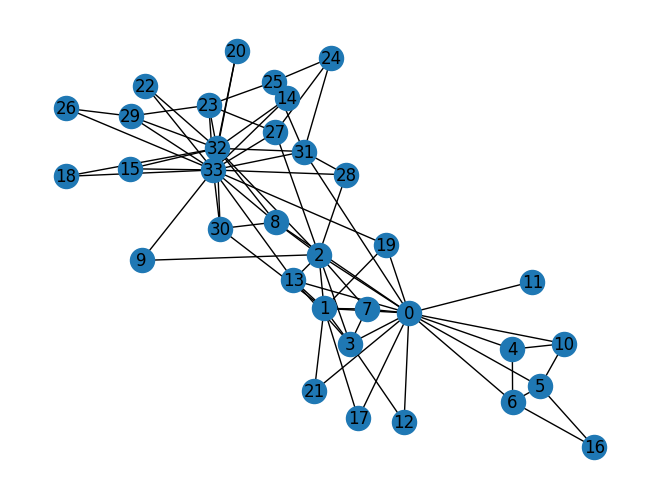

In [ ]:

# https://www.geeksforgeeks.org/k-shell-decomposition-on-social-networks/
# Import required modules
import networkx as nx
import matplotlib.pyplot as plt
  
  
# Check if there is any node left with degree d
def check(h, d):
    f = 0  # there is no node of deg <= d
    for i in h.nodes():
        if (h.degree(i) <= d):
            f = 1
            break
    return f
  
  
# Find list of nodes with particular degree
def find_nodes(h, it):
    set1 = []
    for i in h.nodes():
        if (h.degree(i) <= it):
            set1.append(i)
    return set1
  
  
# Create graph object and add nodes
g = nx.karate_club_graph()
  
  
# Copy the graph
h = g.copy()
it = 1
  
  
# Bucket being filled currently
tmp = []
  
  
# list of lists of buckets
buckets = []
while (1):
    flag = check(h, it)
    if (flag == 0):
        it += 1
        buckets.append(tmp)
        tmp = []
    if (flag == 1):
        node_set = find_nodes(h, it)
        for each in node_set:
            h.remove_node(each)
            tmp.append(each)
    if (h.number_of_nodes() == 0):
        buckets.append(tmp)
        break
print(buckets)
  
  
# Illustrate the Social Network 
# in the form of a graph
nx.draw(g, with_labels=1)
plt.show()

<class 'networkx.classes.graph.Graph'>


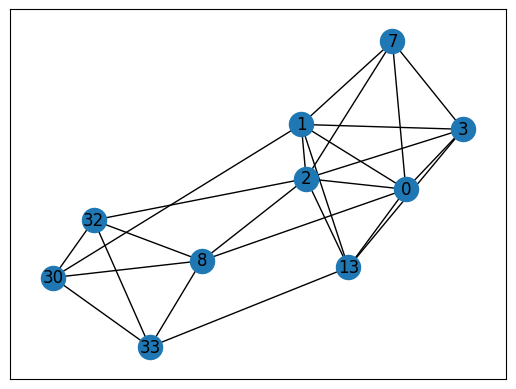

In [ ]:
# https://networkx.org/documentation/networkx-2.0/reference/algorithms/generated/networkx.algorithms.core.k_shell.html

G = nx.karate_club_graph()

k_shell_sub_graph = nx.core.k_shell(G)
print(type(k_shell_sub_graph))
nx.draw_networkx(k_shell_sub_graph)